In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install osmnx
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point, LineString
from shapely.wkt import loads

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 5.3 MB/s eta 0:00:00


In [ ]:
pip install pandas geopandas shapely

In [ ]:
# Load roads data (convert WKT to geometry)
roads_df = pd.read_csv("/content/drive/MyDrive/Computational intelligence/Birmingham.csv")
roads_gdf = gpd.GeoDataFrame(
    roads_df,
    geometry=roads_df['wkt'].apply(loads),
    crs="EPSG:27700"  # British National Grid
)

# Load memorials data (use Easting/Northing for geometry)
trees_df = pd.read_csv("/content/drive/MyDrive/Computational intelligence/birmingham_trees_bng (1).csv")
trees_gdf = gpd.GeoDataFrame(
    trees_df,
    geometry=gpd.points_from_xy(trees_df.easting_bng_utm30, trees_df.northing_bng_utm30), # Use lowercase 'easting' and 'northing'
    crs="EPSG:27700"
)

# Perform nearest neighbor join (requires geopandas >= 0.10.0)
nearest = gpd.sjoin_nearest(
    trees_gdf,
    roads_gdf,
    how='left',
    max_distance=50,  # Only consider trees within 50m of a road
    distance_col='distance_to_road'
)

# Create a list of road indices that have nearby trees
roads_with_trees = nearest[~nearest['index_right'].isna()]['index_right'].unique()

# Add the new column to roads
roads_gdf['has_trees'] = roads_gdf.index.isin(roads_with_trees).astype(str)
roads_gdf['has_trees'] = roads_gdf['has_trees'].replace({
    'True': 'Yes',
    'False': 'No'
})

# Optional: Add count of nearby trees
tree_counts = nearest['index_right'].value_counts()
roads_gdf['trees_count'] = roads_gdf.index.map(tree_counts).fillna(0).astype(int) # Changed trees_gdf_counts to tree_counts

# Save the updated road network (without geometry)
roads_output = roads_gdf.drop(columns=['geometry'])
roads_output.to_csv('Birmingham2_with_nearest_trees.csv', index=False)

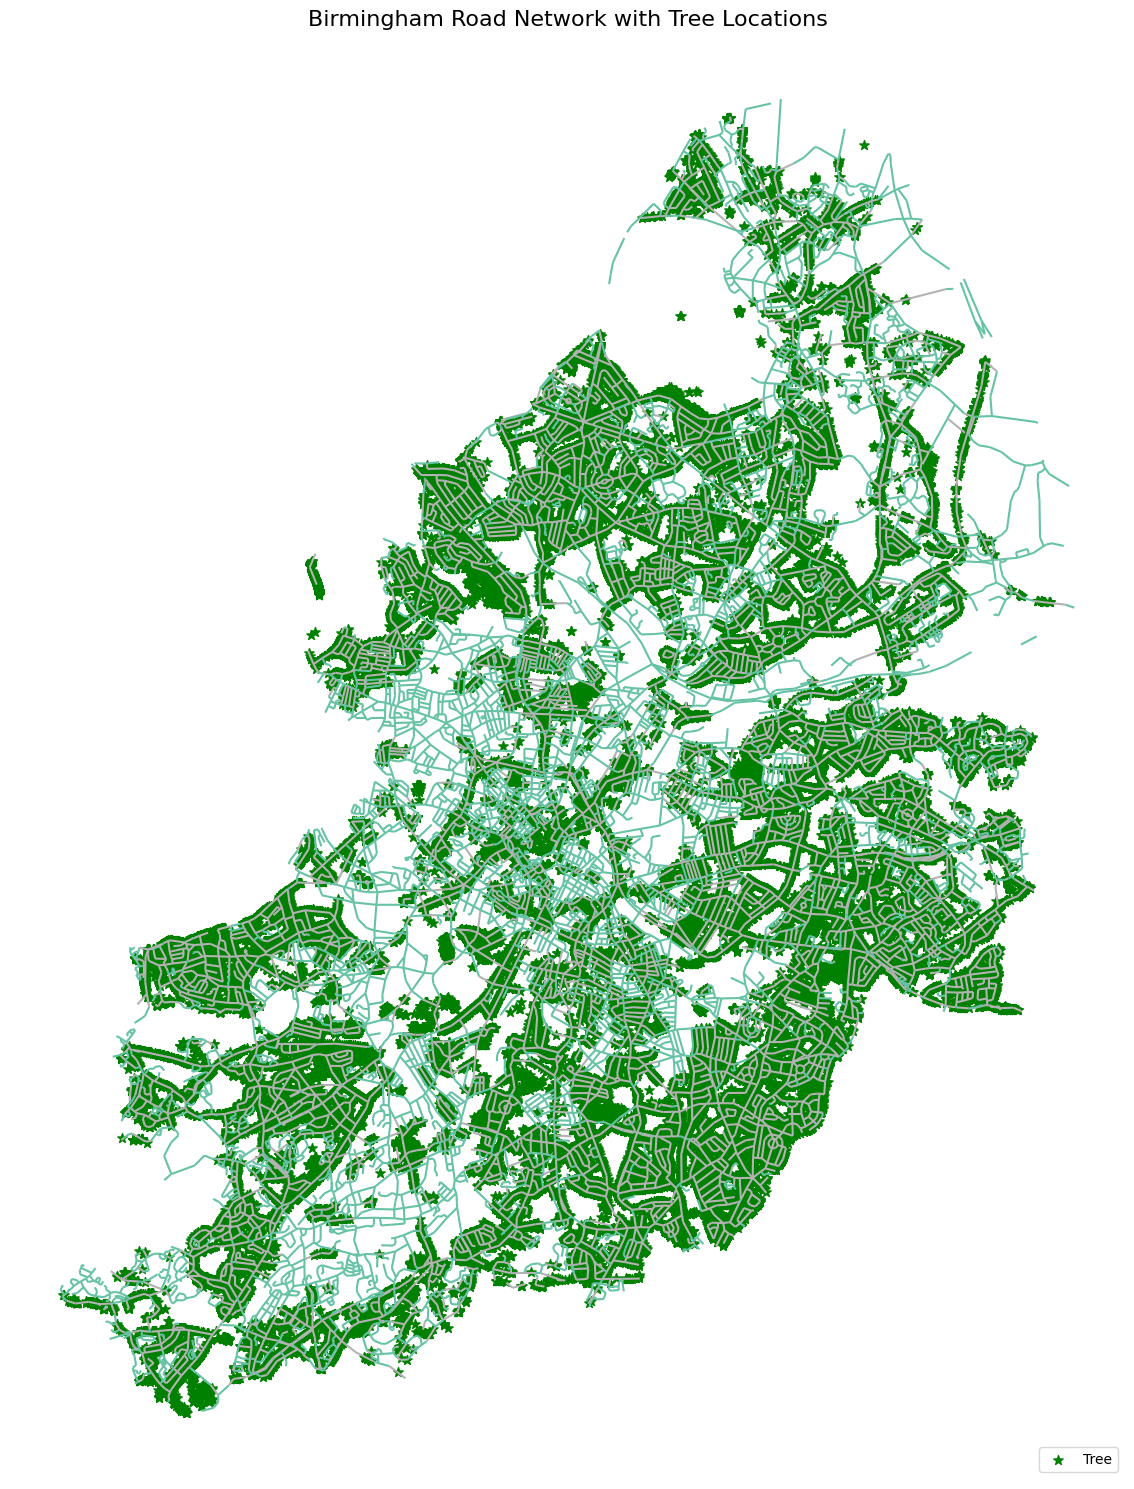

In [ ]:
!pip install contextily
import matplotlib.pyplot as plt
import contextily as ctx

# Create figure
fig, ax = plt.subplots(figsize=(15, 15))

# Plot roads (color by memorial presence)
roads_gdf.plot(
    ax=ax,
    column='has_trees',
    categorical=True,
    cmap='Set2',
    linewidth=1.5,
    legend=True,
    legend_kwds={'title': "Has Trees", 'loc': 'upper right'}
)

# Plot memorial locations
trees_gdf.plot(
    ax=ax,
    color='green',
    markersize=50,
    marker='*',
    edgecolor='green',
    label='Tree'
)

# Customize plot
plt.title('Birmingham Road Network with Tree Locations', fontsize=16)
plt.axis('off')
plt.legend(loc='lower right')
plt.tight_layout()

# Save and show
plt.savefig('birmingham_roads_trees.png', dpi=300, bbox_inches='tight')
plt.show()